# R-CNN Implement
### 2 stage deytector process 
1. Selective search 알고리즘을 통해 객체가 있을 법한 위치의 후보 영역(region proposal)을 2000개 이하로 추출하여, 227x227 크기로 warp
2. region proposal을 fine tuning된 AlexNet에 입력하여 2000x4096 크기의 feature vector를 추출
3. 추출되 feature vector를 linear SVM 모델과 Bounding box regressor 모델에 입력하여 각각 confidence score과 조정되 bounding box 좌표를 얻습니다.
4. Non maximum suppression 알고리즘을 적용하여 최적의 bounding box를 출력합니다.

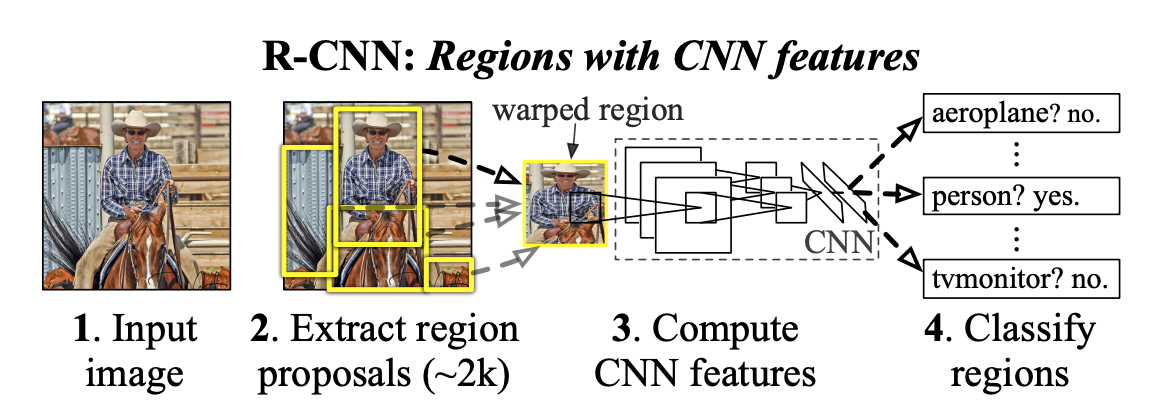

In [4]:
import numpy as np
import os, glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf1


os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf1.Session(config=config)

2024-12-18 17:19:17.843045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20169 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


## 1. 데이터 압축풀기

In [5]:
!unzip -o Images.zip

Archive:  Images.zip
  inflating: Images/airplane_007.jpg  
  inflating: Images/airplane_006.jpg  
  inflating: Images/airplane_005.jpg  
  inflating: Images/airplane_004.jpg  
  inflating: Images/airplane_003.jpg  
  inflating: Images/airplane_002.jpg  
  inflating: Images/airplane_001.jpg  
  inflating: Images/428503.jpg       
  inflating: Images/428501.jpg       
  inflating: Images/428492.jpg       
  inflating: Images/428491.jpg       
  inflating: Images/428483.jpg       
  inflating: Images/428482.jpg       
  inflating: Images/428481.jpg       
  inflating: Images/428472.jpg       
  inflating: Images/428462.jpg       
  inflating: Images/428461.jpg       
  inflating: Images/428452.jpg       
  inflating: Images/428451.jpg       
  inflating: Images/42850.jpg        
  inflating: Images/42849.jpg        
  inflating: Images/42848.jpg        
  inflating: Images/42847.jpg        
  inflating: Images/airplane_309.jpg  
  inflating: Images/airplane_319.jpg  
  inflating: Images/

In [8]:
!unzip -o Airplanes_Annotations.zip

Archive:  Airplanes_Annotations.zip
 extracting: Airplanes_Annotations/airplane_095.csv  
  inflating: Airplanes_Annotations/airplane_094.csv  
  inflating: Airplanes_Annotations/airplane_093.csv  
  inflating: Airplanes_Annotations/airplane_092.csv  
  inflating: Airplanes_Annotations/airplane_091.csv  
  inflating: Airplanes_Annotations/airplane_090.csv  
 extracting: Airplanes_Annotations/airplane_089.csv  
 extracting: Airplanes_Annotations/airplane_088.csv  
 extracting: Airplanes_Annotations/airplane_087.csv  
 extracting: Airplanes_Annotations/airplane_086.csv  
  inflating: Airplanes_Annotations/airplane_085.csv  
 extracting: Airplanes_Annotations/airplane_084.csv  
  inflating: Airplanes_Annotations/airplane_083.csv  
  inflating: Airplanes_Annotations/airplane_082.csv  
 extracting: Airplanes_Annotations/airplane_081.csv  
 extracting: Airplanes_Annotations/airplane_080.csv  
 extracting: Airplanes_Annotations/airplane_079.csv  
  inflating: Airplanes_Annotations/airplane_07

In [5]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
path = "Images"
annot = "Airplanes_Annotations"

## 2. Image와 각 Annotation 확인

airplane_190.jpg


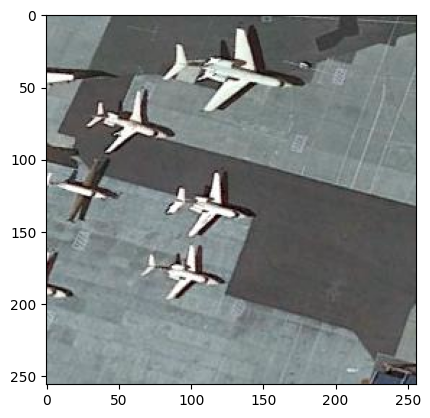

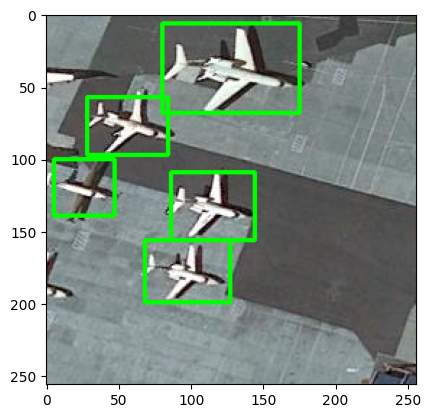

In [7]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 2)
        plt.figure()
        plt.imshow(img)
        break

## 3. Region Proposal 추출
* Selective search 알고리즘을 통해 객체가 있을법한 위치인 Region proposal을 추출합니다.
* Selective search 알고리즘은 색감, 질감, 영역 크기 등을 이용해 non-objective segmentation

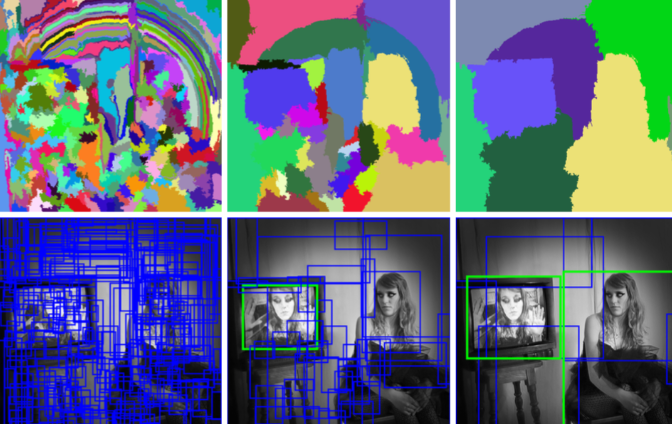

### 3-1. 한 이미지에 selective search 진행
* cv2.setOptimized() : 최적화되 코드를 활성화
* cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() : 기본 매개변수를 사용하여 selective search segmentation 개체를 만드는 코드
* setBaseImage() : segmentation 실행할 입력 이미지를 설정
* switchToSelectiveSearchFast() : 빠르지만 회수율이 낮은 방식으로 진행
* process() : 입력 이미지에 selective search 진행

In [8]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

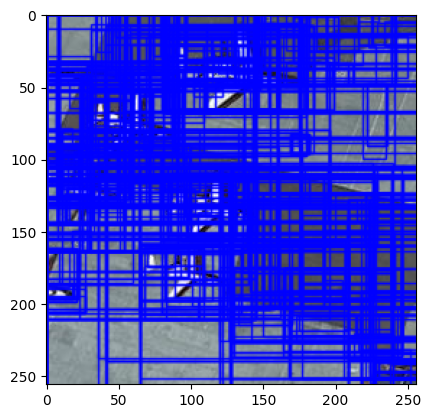

In [9]:
im = cv2.imread(os.path.join(path,"airplane_190.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    # print(x,y,w,h)
    # imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)
plt.imshow(imOut)

### 3-2. 학습 데이터 생성
1. Selective Search Segmentation을 이용해 객체 후보 영역을 생성
2. Ground Truth 값과 IoU를 계산하여 학습 데이터 생성

In [10]:
train_images=[]
train_labels=[]

**3-2-1. IoU 계산**

In [11]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**3-2-2. 전체 이미지에 Selective Search Segmentation 적용후 IoU 값 계산**
* IoU > 0.7 : 그 Region을 Object (비행기의 라벨인 1로 라벨링)
* IoU < 0.3 : 그 Region을 Background (배경의 라벨인 0으로 라벨링)

In [12]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_190.jpg
inside
1 airplane_041.jpg
inside
2 airplane_636.jpg
3 airplane_434.jpg
inside
4 airplane_164.jpg
5 airplane_573.jpg
6 airplane_611.jpg
7 airplane_112.jpg
inside
8 airplane_614.jpg
9 airplane_663.jpg
10 airplane_589.jpg
11 airplane_279.jpg
12 airplane_572.jpg
13 airplane_237.jpg
14 airplane_401.jpg
15 airplane_195.jpg
16 airplane_028.jpg
17 airplane_403.jpg
18 airplane_526.jpg
inside
19 airplane_244.jpg
20 airplane_151.jpg
inside
21 airplane_167.jpg
22 airplane_449.jpg
23 airplane_494.jpg
24 airplane_349.jpg
25 airplane_159.jpg
26 airplane_698.jpg
27 airplane_484.jpg
28 airplane_623.jpg
29 airplane_078.jpg
30 airplane_466.jpg
31 airplane_565.jpg
32 airplane_292.jpg
33 airplane_393.jpg
34 airplane_578.jpg
35 airplane_076.jpg
36 airplane_541.jpg
37 airplane_618.jpg
38 airplane_222.jpg
39 airplane_510.jpg
40 airplane_207.jpg
41 airplane_255.jpg
42 airplane_281.jpg
43 airplane_129.jpg
44 airplane_436.jpg
45 airplane_172.jpg
46 airplane_397.jpg
47 airplane_364.jpg
48 airpl

**3-2-3. Region Proposal Data 소개**
* X_new : Selective Search Segmentation을 통해 만들어진 각 Region Proposal
* y_new : 0 or 1로 Region Proposal에 Object의 여부

In [24]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

Train Region Proposal : (30229, 224, 224, 3)


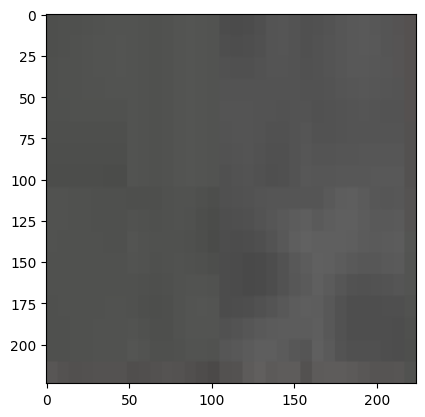

In [25]:
print("Train Region Proposal :", X_new.shape)
plt.imshow(X_new[0])

In [26]:
print("Label :", y_new.shape)
print(y_new)

Label : (30229,)
[0 0 0 ... 1 1 1]


## 4. 모델 학습
* AlexNet 대신 vgg16 모델 사용
* vgg16 모형에 마지막 부분만 바꿔주고 윗 부분 weights를 고정
* Optimizer는 Adam으로 loss는 categorical_cross_entropy로 설정하고 판단 척도로 accuracy를 설정하여 compile
* 논문에서는 CNN을 이용하여 feature을 뽑은 후 linear SVMs를 이용하였는데 위 코드에서는 두 개를 합쳐 vgg16 모형을 변형하여 바로 Object인지 배경인지 분류

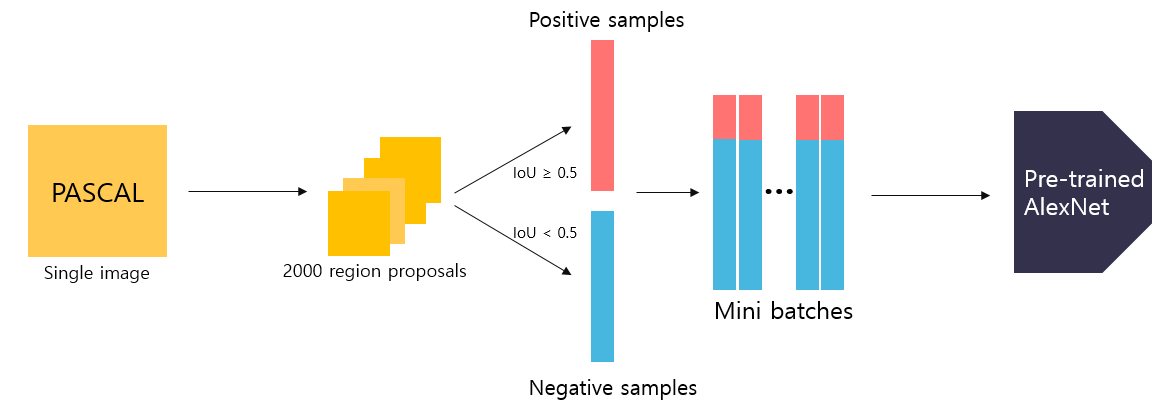

In [27]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [28]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [30]:
X= vggmodel.layers[-2].output

In [31]:
predictions = Dense(2, activation="softmax")(X)

In [32]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [33]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [34]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [35]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [37]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [38]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [39]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [40]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [41]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [43]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [44]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/tmp/ipykernel_668296/3734971591.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/1000


2024-12-18 17:27:16.438586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-12-18 17:27:17.515179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-18 17:27:17.559080: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xf4e33ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-18 17:27:17.559142: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-12-18 17:27:17.570422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 17:27:17.732040: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

10/10 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.7844
Epoch 1: val_loss improved from inf to 0.65982, saving model to ieeercnn_vgg16_1.h5


/home/a202162017/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 10s 667ms/step - loss: 0.9504 - accuracy: 0.7844 - val_loss: 0.6598 - val_accuracy: 0.6094
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.8094
Epoch 2: val_loss improved from 0.65982 to 0.22917, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 6s 634ms/step - loss: 0.4985 - accuracy: 0.8094 - val_loss: 0.2292 - val_accuracy: 0.8750
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8625
Epoch 3: val_loss did not improve from 0.22917
10/10 [==============================] - 3s 343ms/step - loss: 0.3452 - accuracy: 0.8625 - val_loss: 0.4162 - val_accuracy: 0.8906
Epoch 4/1000
10/10 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8750
Epoch 4: val_loss did not improve from 0.22917
10/10 [==============================] - 4s 362ms/step - loss: 0.3288 - accuracy: 0.8750 - val_loss: 0.2441 - val_accuracy: 0.8906
Epoch

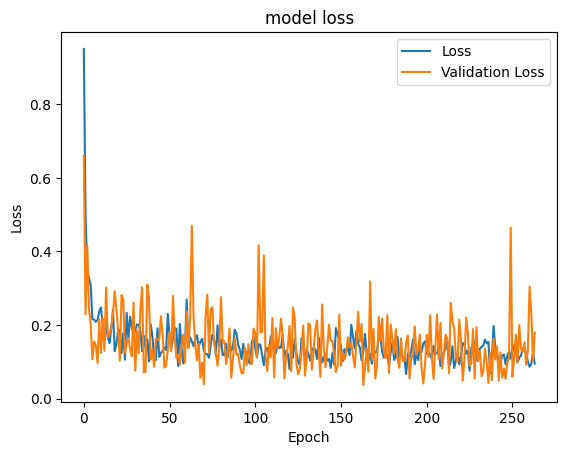

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

## 5. 테스트 결과

1/1 [==============================] - 0s 23ms/step
plane


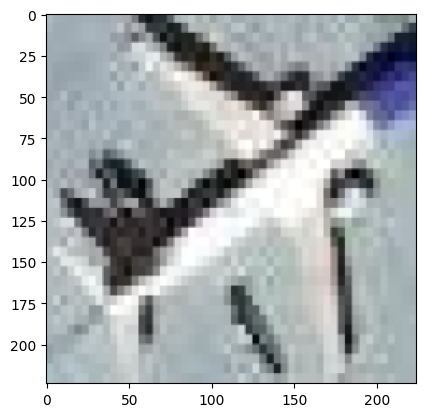

In [48]:
im = X_test[1602]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

1/1 [==============================] - 0s 24ms/step


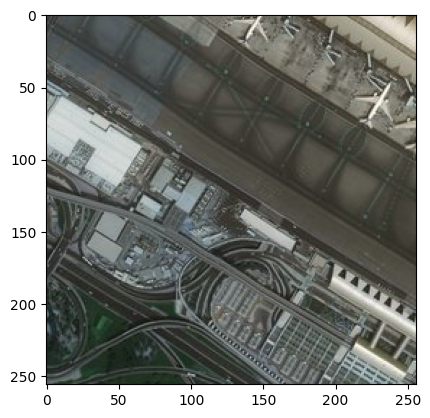

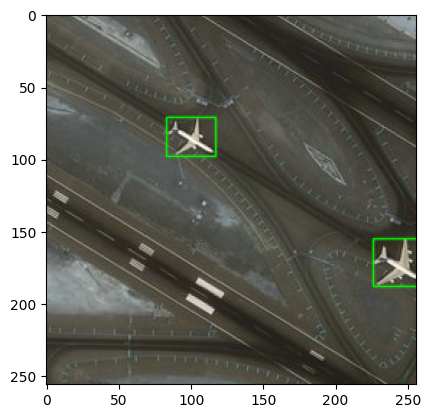

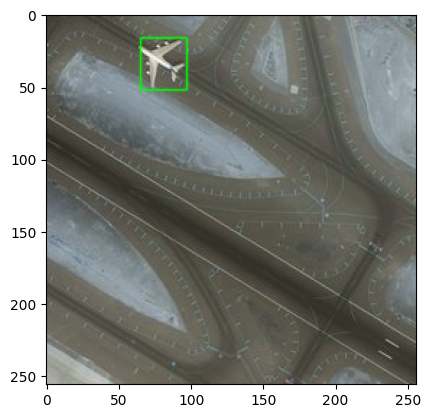

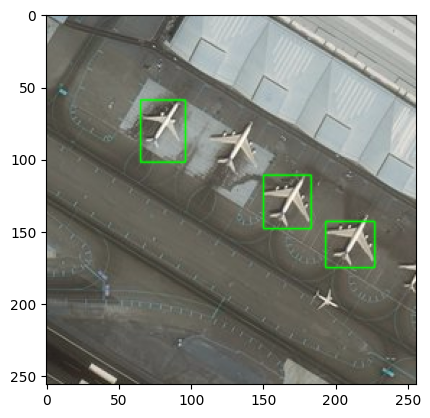

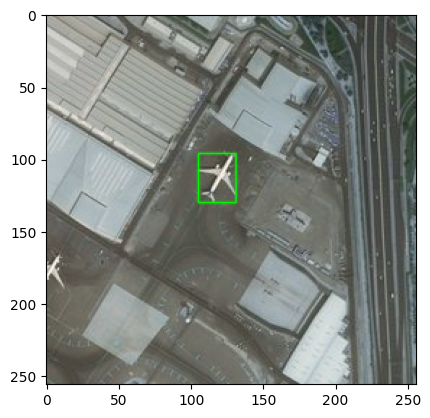

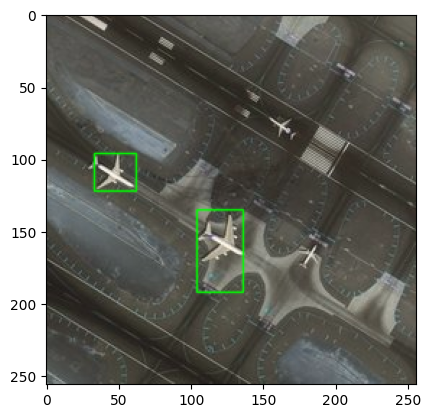

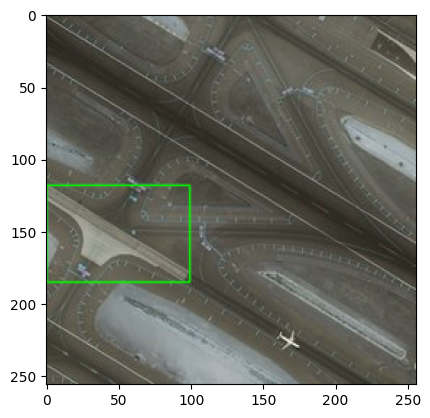

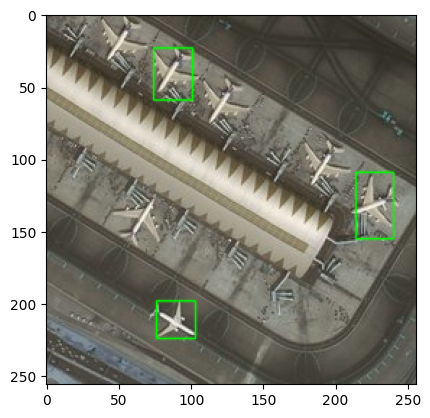

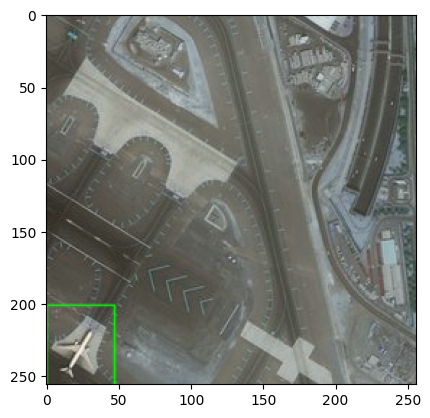

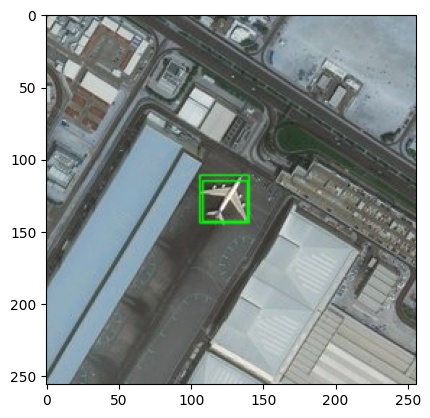

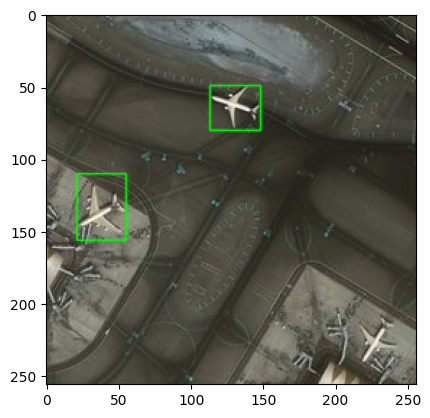

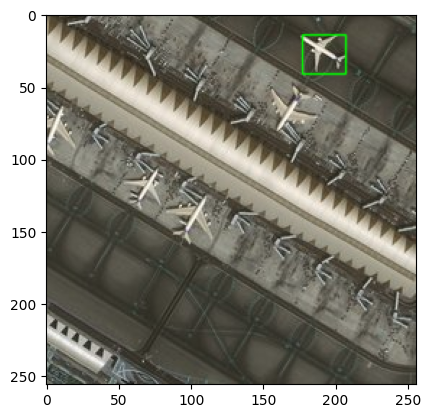

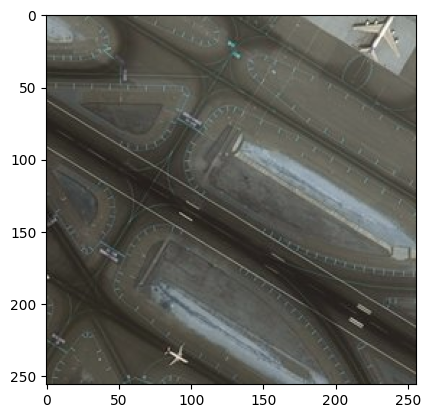

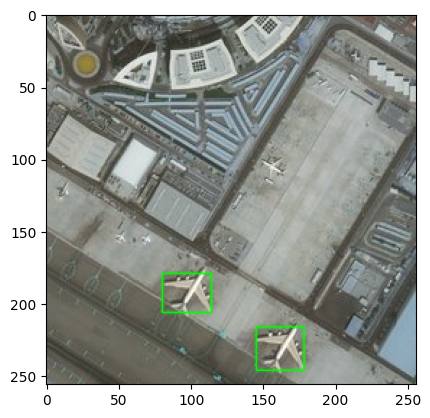

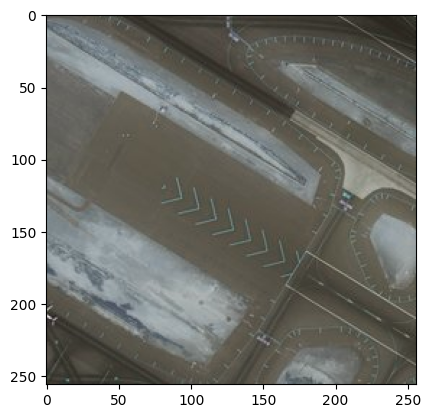

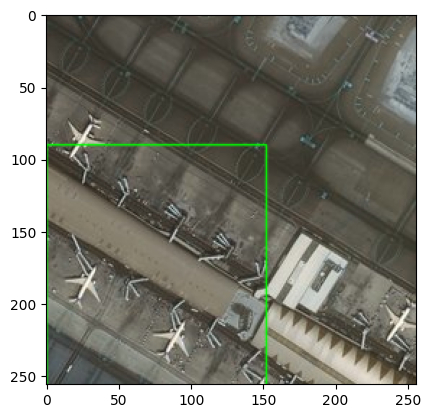

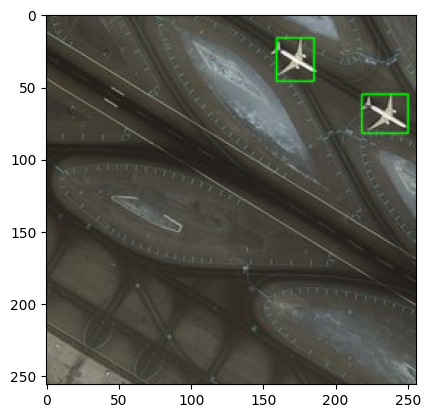

In [49]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)